In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 

import string
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import metrics

from time import time

import warnings
warnings.filterwarnings("ignore")

Text Classification 

The dataset chosen consists of about 8000 rows and 15 columns, with texts related to the US Politics, The column 'relevant' consists of Binary values YES or NO depicting if the Text is relevant to the context.
A third class stating 'NOT SURE' is also represented but has been dropped due to inadequate number of values(only 9 out of 8000). 

The data is highly imbalanced with 6.5k relevant articles, and 1.4 irrelavant articles. 

EDA

In [2]:
df = pd.read_csv('US-Economic-News.csv', encoding = 'ISO-8859-1')

In [3]:
df

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.6400,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.0000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.0000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.6750,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.6400,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,830985632,False,finalized,3,11/17/15 18:16,7.0,0.3511,yes,0.6641,wapo_152454634,2/11/52,"Sawyer Sees Strong Economy For 2 Years, Truce ...",NaN,NaN,Secretary of Commerce Charles W. Sawyer said y...
7996,830985633,False,finalized,3,11/18/15 8:10,NaN,NaN,no,1.0000,wapo_410349039,12/13/09,Oil's losses are airlines' gains,NaN,NaN,"U.S. stocks inched up last week, overcoming co..."
7997,830985634,False,finalized,3,11/18/15 12:12,NaN,NaN,no,1.0000,wapo_410346237,12/18/09,Full Senate to vote on Bernanke; PANEL ADVANCE...,NaN,NaN,Ben S. Bernanke cleared a key hurdle Thursday ...
7998,830985635,False,finalized,3,11/18/15 7:17,NaN,0.0000,no,0.6855,wapo_307808606,1/10/95,Reinventing Opportunities,NaN,NaN,The White House's push to contract out many fe...


In [4]:
df['relevance'].value_counts()

relevance
no          6571
yes         1420
not sure       9
Name: count, dtype: int64

In [5]:
df = df[df.relevance != "not sure"]
df.shape

(7991, 15)

In [6]:
data = df[["text","relevance"]] # taking text input and output variable as relevance
data['relevance'] = data['relevance'].map({'yes':1, 'no':0}) # `Mapping relevant as 1, not-relevant as 0 
data.shape

(7991, 2)

In [7]:
data

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1
...,...,...
7995,Secretary of Commerce Charles W. Sawyer said y...,1
7996,"U.S. stocks inched up last week, overcoming co...",0
7997,Ben S. Bernanke cleared a key hurdle Thursday ...,0
7998,The White House's push to contract out many fe...,0


In [8]:
data['text'][0] #Understanding the neccesary text cleaning to be done by examining a single article 

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

In [9]:
data['text'][3]

'The statistics on the enormous costs of employee drug abuse are well known (at least $70 billion per year, according to December 1985 testimony before the House Labor Subcommittee on Health and Safety). Management is under pressure to reduce productivity losses, turnover, insurance costs and the risk of lawsuits for personal and property damage caused by drug-impaired workers. Management also is under sales pressure from a growing cadre of laboratories, test-kit manufacturers and consultants who extol the virtues of testing. A common argument is the following: "Your competitors are starting to require drug tests. If you don\'t, their work force will be clean and you will end up with all the junkies."</br></br>Many companies that have implemented widespread drug-testing programs, however, have learned that there is a downside to testing. They have experienced the protests of employees and civil libertarians and have watched the proliferation of lawsuits alleging invasion of privacy, de

Data Cleaning 

In [10]:
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
stop = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

# NLP preprocessing has been implemented lower stopwords removal, lemmatisation, lowering cases. 
def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))
    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ") 
    doc = doc.replace("-", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stop])    
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

In [12]:
data['text'] = data['text'].apply(clean)
data.head()

,text,relevance
0,new york yields certificates deposit offered m...,1
1,wall street journal online br morning brief lo...,0
2,effort achieve banking reform negotiators admi...,0
3,statistics enormous costs employee drug abuse ...,0
4,new york indecision marked dollar tone traders...,1


In [66]:
data['text'][0]

'new york yields certificates deposit offered major banks dropped tenth percentage point latest week reflecting overall decline short term interest rates br small denomination consumer cds sold directly banks average yield six month deposits fell week ended yesterday according bank survey money markets information service br three month consumer deposits average yield sank week according banks survey new york paying less small denomination declines somewhat smaller five year consumer cds eased said br yields three month six month bills sold auction plummeted fifth percentage point previous week respectively'

Feature Extraction - TFIDF 

In [13]:
# Applying TFIDF Vectoriser to form the vector array from the textual data

docs = list(data['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [14]:
x = docs 
y = data['relevance']
print(x.shape, y.shape)

(7991, 20000) (7991,)


DATASET PREP FOR TRAINING

In [15]:
# Splitting the data into 8:2 ratio 

SEED=123
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=SEED, stratify=y)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(6392, 20000) (6392,)
(1599, 20000) (1599,)


In [16]:
# Function for Evaluation 

def evaluation(model_name, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    # Using the model to predict
    model = model_name
    model.fit(x_train, y_train)
    y_pred_test = model.predict(x_test)
    print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
    # Classification Report of the Model
    print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))
    #Confusion Matrix for the Model 
    cm = confusion_matrix(y_test, y_pred_test)
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'], 
                            index=['Predict Positive', 'Predict Negative'])
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.show()
    #ROC-AUC Curve
    probs = model.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return
    

Checking different models on the Raw Data

1. Guassian Naive Bayes - The model was successful in giving a good accuracy of 78.5%. However when we observe the Classification report, There is a huge difference in the F1-Score of class 1 and class 2. Model has perfomed well on the heavily weighed data, but for the class with less data score is lesser

Testing Accuracy score: 0.7854909318323953
              precision    recall  f1-score   support

not relevant       0.84      0.92      0.88      1315
    relevant       0.30      0.16      0.21       284

    accuracy                           0.79      1599
   macro avg       0.57      0.54      0.54      1599
weighted avg       0.74      0.79      0.76      1599



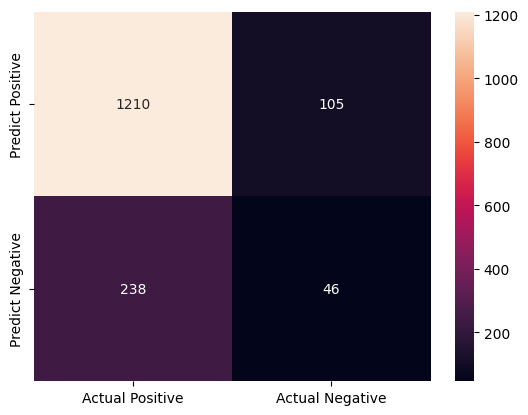

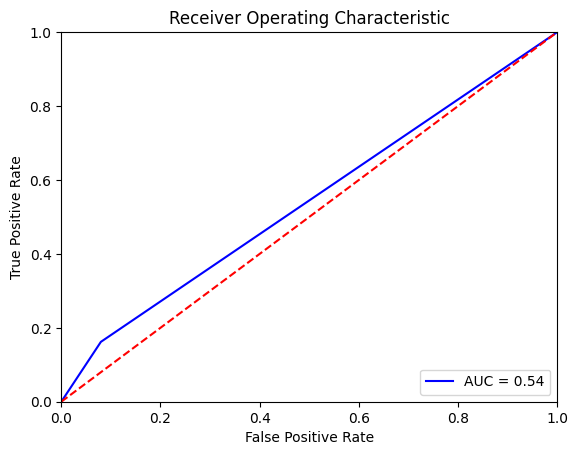

In [17]:
evaluation(GaussianNB())

2. Logistic Regression - The model is quite complex when compared to the Naive Bayes and by including class_weights parameter the model has to exprectedly penalise the majority data and form a balance. Hence, we notice that the model was successful in giving a good accuracy of 82.3%. However when we observe the Classification report, There is a huge difference in the F1-Score of class 1 and class 2. Model has overfitted on majority data. But the evaluation in ROC-AUC Curve shows a good difference between true positives and False posiitves 



Testing Accuracy score: 0.8230143839899937
              precision    recall  f1-score   support

not relevant       0.83      0.98      0.90      1315
    relevant       0.51      0.10      0.17       284

    accuracy                           0.82      1599
   macro avg       0.67      0.54      0.53      1599
weighted avg       0.78      0.82      0.77      1599



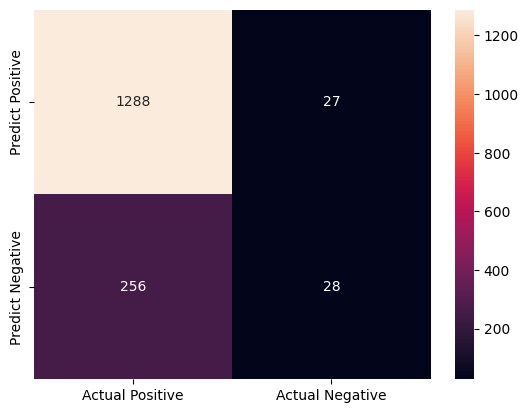

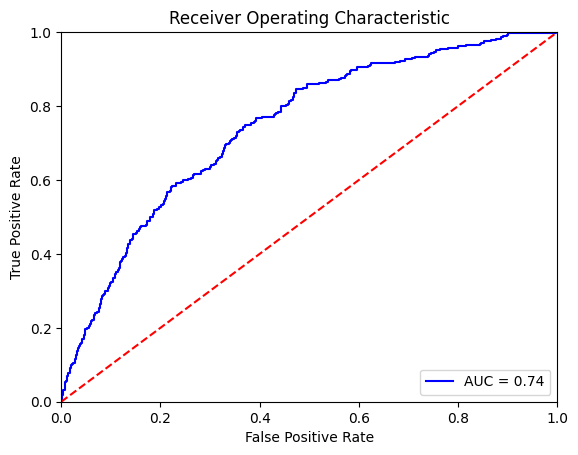

In [18]:
evaluation(LogisticRegression(random_state=SEED))

Testing Accuracy score: 0.8223889931207005
              precision    recall  f1-score   support

not relevant       0.82      1.00      0.90      1315
    relevant       0.00      0.00      0.00       284

    accuracy                           0.82      1599
   macro avg       0.41      0.50      0.45      1599
weighted avg       0.68      0.82      0.74      1599



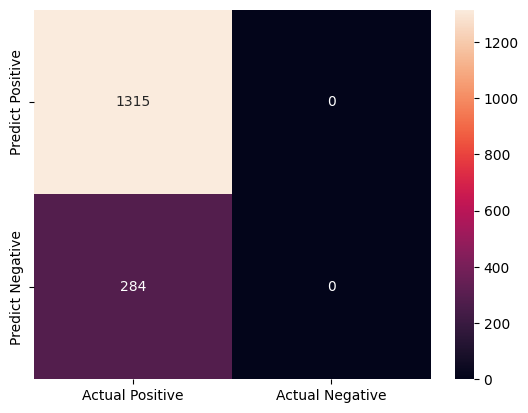

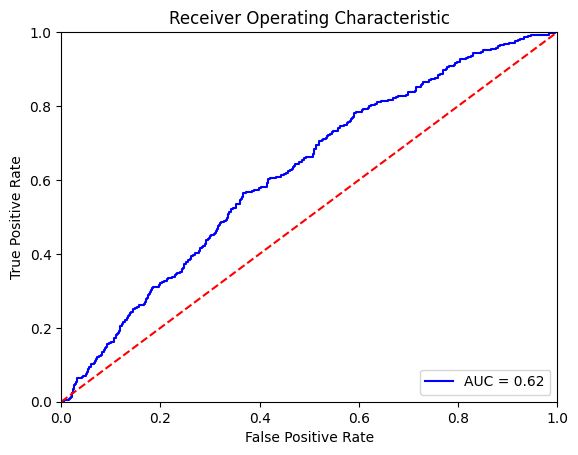

In [20]:
evaluation(MultinomialNB())

Handling the class Imbalance 

1. SMOTE - It is a technique to handle the imbalanced dataset by oversampling the minority class. Initially we observe hig variations in the classes (relevant articles and irrelevant articles) which is handles with SMOTE

In [21]:
y.value_counts()

relevance
0    6571
1    1420
Name: count, dtype: int64

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote.fit_resample(x,y)

In [23]:
y_sm.value_counts()

relevance
1    6571
0    6571
Name: count, dtype: int64

In [28]:
x_train_sm,x_test_sm,y_train_sm,y_test_sm=train_test_split(x_sm, y_sm, test_size=0.2, random_state=SEED, stratify=y_sm)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(10513, 20000) (10513,)
(2629, 20000) (2629,)


Applying the Model with Oversampled Data

1. GuassianNB -Here in this case we have observed that the evaluation results are well balanced 

Testing Accuracy score: 0.9383796120197794
              precision    recall  f1-score   support

not relevant       0.98      0.90      0.94      1315
    relevant       0.90      0.98      0.94      1314

    accuracy                           0.94      2629
   macro avg       0.94      0.94      0.94      2629
weighted avg       0.94      0.94      0.94      2629



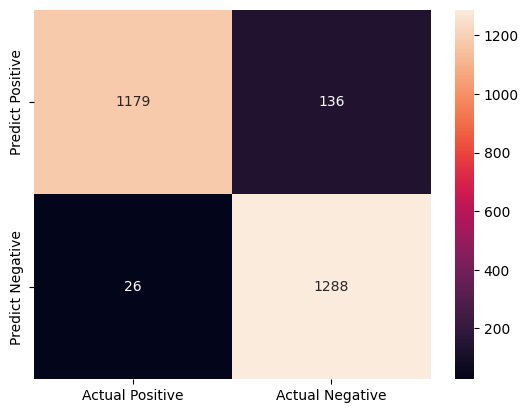

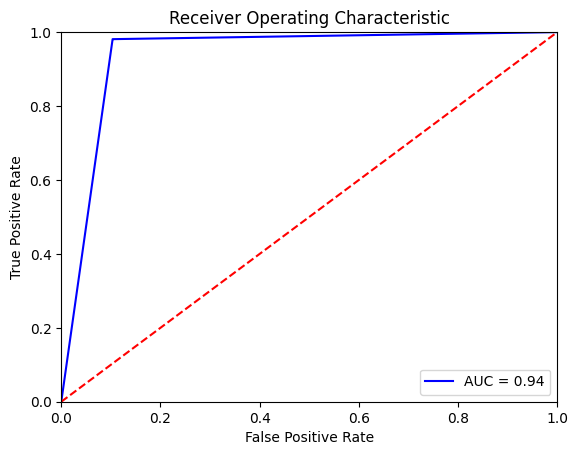

In [30]:
evaluation(GaussianNB(), x_train=x_train_sm, y_train=y_train_sm, x_test=x_test_sm, y_test=y_test_sm)

MultinomialNB

Testing Accuracy score: 0.7744389501711677
              precision    recall  f1-score   support

not relevant       0.87      0.64      0.74      1315
    relevant       0.72      0.90      0.80      1314

    accuracy                           0.77      2629
   macro avg       0.79      0.77      0.77      2629
weighted avg       0.79      0.77      0.77      2629



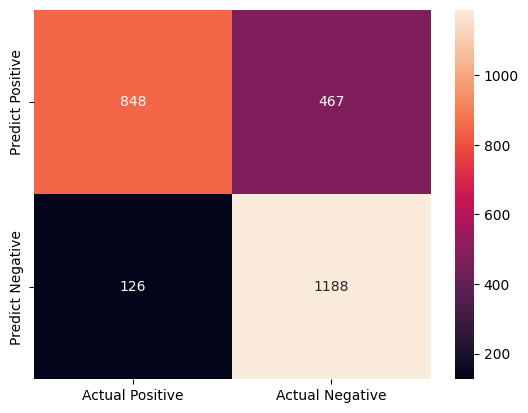

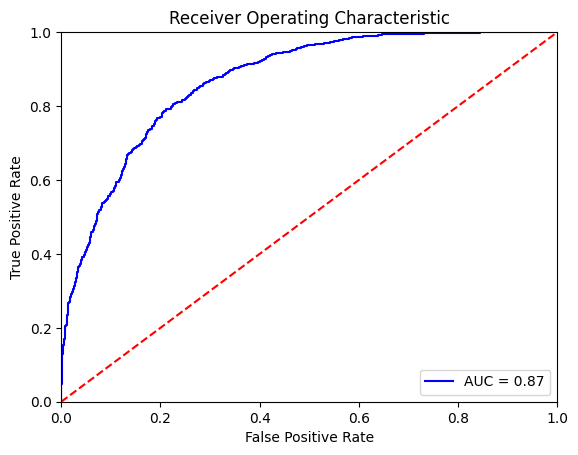

In [31]:
evaluation(MultinomialNB(), x_train=x_train_sm, y_train=y_train_sm, x_test=x_test_sm, y_test=y_test_sm)

Logistic Regression 

Testing Accuracy score: 0.8436667934575884
              precision    recall  f1-score   support

not relevant       0.87      0.81      0.84      1315
    relevant       0.82      0.88      0.85      1314

    accuracy                           0.84      2629
   macro avg       0.85      0.84      0.84      2629
weighted avg       0.85      0.84      0.84      2629



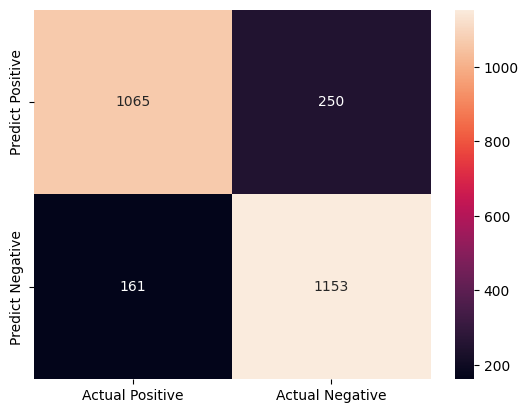

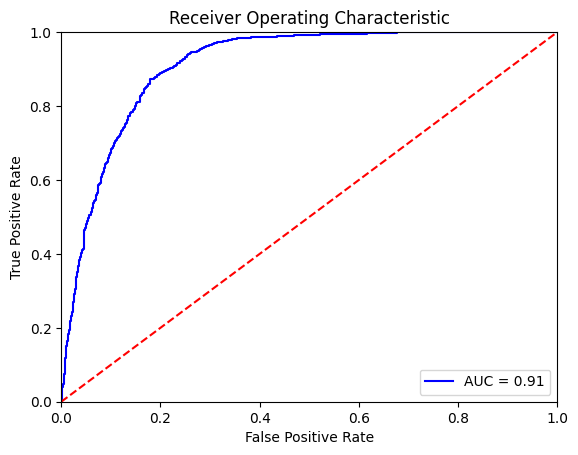

In [32]:
evaluation(LogisticRegression(), x_train=x_train_sm, y_train=y_train_sm, x_test=x_test_sm, y_test=y_test_sm)

2. Ensembling - Here we divide the majority data into smaller groups to match with the minority data, apply the specified model for each samples and processed the average evaluation results for the same

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=15, stratify=y)

In [35]:
y_train.value_counts()

relevance
0    5256
1    1136
Name: count, dtype: int64

In [36]:
df_class0 = data[data.relevance==0]
df_class1 = data[data.relevance==1]

In [37]:
def get_train_batch(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)
    x_train = df_train.text
    tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
    tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(x_train)
    x_train = tfidf_vectorizer_vectors.toarray()
    y_train = df_train.relevance
    return x_train, y_train   

In [38]:
x_train_en, y_train_en = get_train_batch(df_class0, df_class1, 0, 1500)

In [39]:
x_train_en.shape

(2920, 20000)

In [40]:
y_train_en.value_counts()

relevance
0    1500
1    1420
Name: count, dtype: int64

Logistic Regression

Testing Accuracy score: 0.8223889931207005
              precision    recall  f1-score   support

not relevant       0.82      1.00      0.90      1315
    relevant       0.00      0.00      0.00       284

    accuracy                           0.82      1599
   macro avg       0.41      0.50      0.45      1599
weighted avg       0.68      0.82      0.74      1599



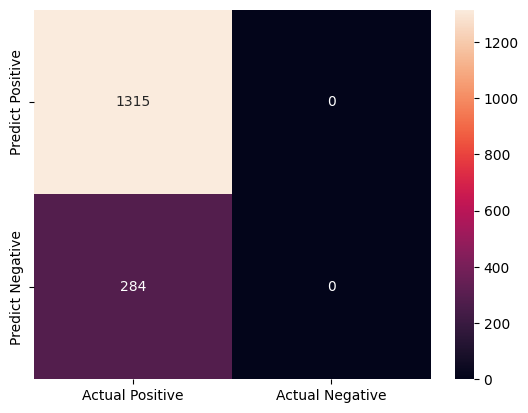

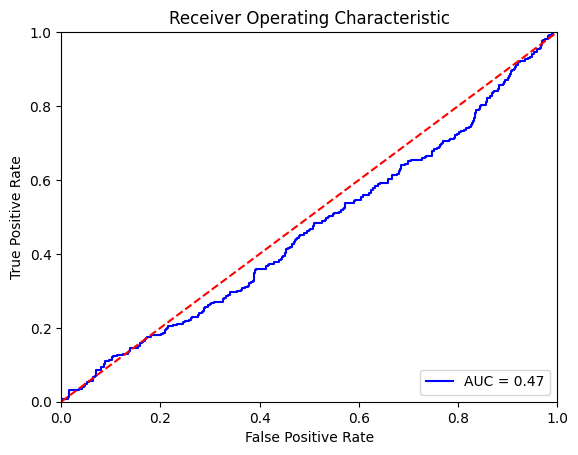

In [42]:
evaluation(LogisticRegression(random_state=SEED), x_train=x_train_en, y_train=y_train_en, x_test=x_test, y_test=y_test )

GuassianNB

Testing Accuracy score: 0.701688555347092
              precision    recall  f1-score   support

not relevant       0.82      0.82      0.82      1315
    relevant       0.16      0.16      0.16       284

    accuracy                           0.70      1599
   macro avg       0.49      0.49      0.49      1599
weighted avg       0.70      0.70      0.70      1599



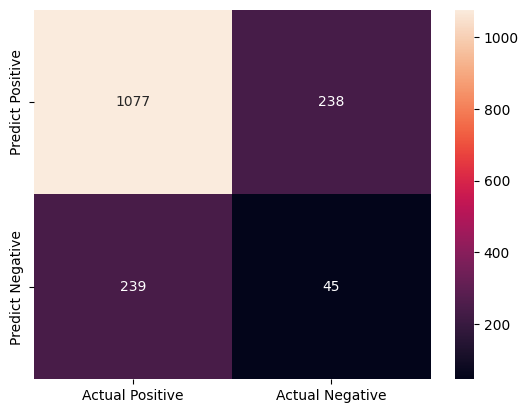

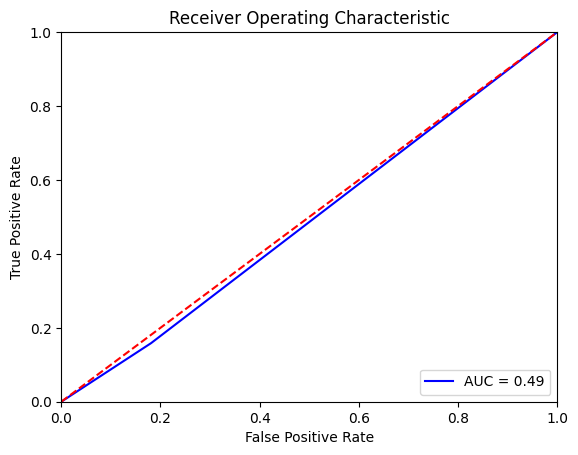

In [43]:
evaluation(GaussianNB(),  x_train=x_train_en, y_train=y_train_en, x_test=x_test, y_test=y_test)

MutlinomialNB

Testing Accuracy score: 0.7367104440275172
              precision    recall  f1-score   support

not relevant       0.82      0.87      0.85      1315
    relevant       0.15      0.11      0.12       284

    accuracy                           0.74      1599
   macro avg       0.49      0.49      0.48      1599
weighted avg       0.70      0.74      0.72      1599



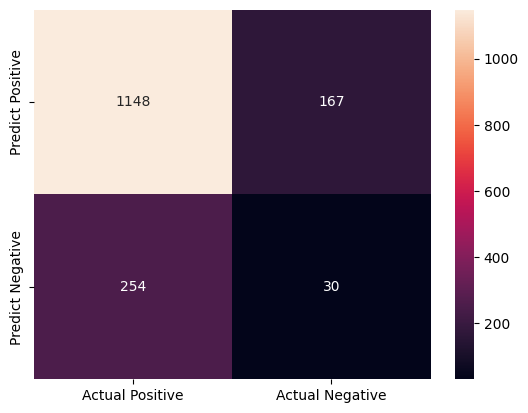

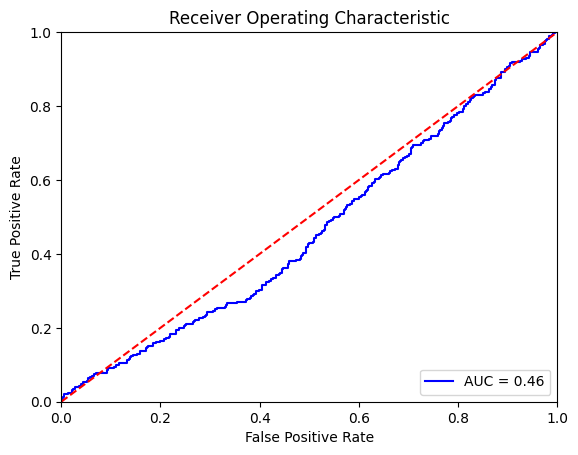

In [44]:
evaluation(MultinomialNB(),  x_train=x_train_en, y_train=y_train_en, x_test=x_test, y_test=y_test)

Expectation - ensembling is also a technique to handle the imblanced data however in the case it has performed poorly fo the base models considered. 


Hyperparamter Tuning

In [51]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [52]:
# Define base classifiers
c1 = LogisticRegression()
c2 = GaussianNB() 
c3 = MultinomialNB()

In [62]:
#  a voting classifier
voting_clf = VotingClassifier(estimators=[('lr', c1), ('gnb', c2), ('mnb', c3)], voting='soft')

In [63]:
param_grid = {
    'lr__C': [0.1, 1, 10, 100],
    'lr__solver': ['liblinear', 'lbfgs'],
    'lr__max_iter': [100, 200, 300],
    'gnb__priors': [None],  # GaussianNB parameters
    'mnb__alpha': [0.1, 0.5, 1.0, 2.0]  # MultinomialNB parameter
}


In [64]:
grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(x_sm, y_sm)


GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('lr',
                                                     LogisticRegression()),
                                                    ('gnb', GaussianNB()),
                                                    ('mnb', MultinomialNB())],
                                        voting='soft'),
             param_grid={'gnb__priors': [None], 'lr__C': [0.1, 1, 10, 100],
                         'lr__max_iter': [100, 200, 300],
                         'lr__solver': ['liblinear', 'lbfgs'],
                         'mnb__alpha': [0.1, 0.5, 1.0, 2.0]},
             scoring='f1')

In [67]:
print("Best parameters found: ", grid_search.best_params_)
y_pred = grid_search.predict(x_test)
print(classification_report(y_test, y_pred))

Best parameters found:  {'gnb__priors': None, 'lr__C': 100, 'lr__max_iter': 100, 'lr__solver': 'liblinear', 'mnb__alpha': 0.1}
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1315
           1       0.73      1.00      0.84       284

    accuracy                           0.93      1599
   macro avg       0.86      0.96      0.90      1599
weighted avg       0.95      0.93      0.94      1599



Testing Accuracy score: 0.7267041901188243
              precision    recall  f1-score   support

not relevant       0.82      0.86      0.84      1315
    relevant       0.16      0.12      0.14       284

    accuracy                           0.73      1599
   macro avg       0.49      0.49      0.49      1599
weighted avg       0.70      0.73      0.71      1599



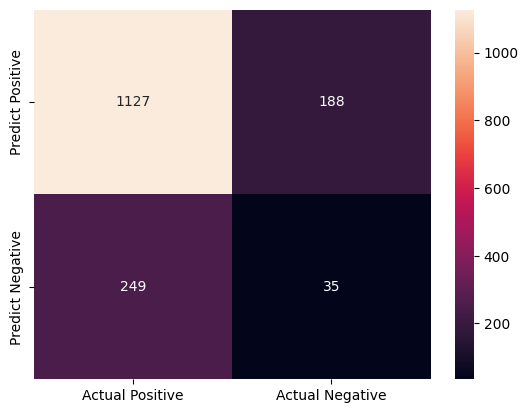

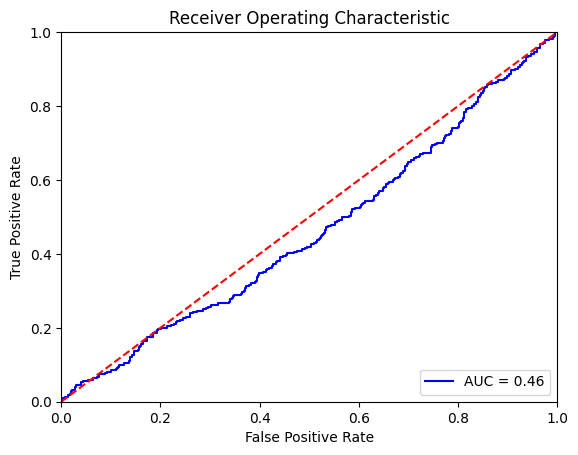

In [68]:
evaluation(grid_search, x_train=x_train_sm, y_train=y_train_sm, x_test=x_test, y_test=y_test)